# Exploratory Analysis of Telco Churn Dataset

## Imports and Useful Paths

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific and visual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading Datasets

In [2]:
from churn_detection.paths import TRANSFORMED_DATA_DIR

In [3]:
train_df = pd.read_feather(TRANSFORMED_DATA_DIR / "train.feather")
val_df = pd.read_feather(TRANSFORMED_DATA_DIR / "validation.feather")

## Target Analysis

In [4]:
from churn_detection.visualization import plot_pie

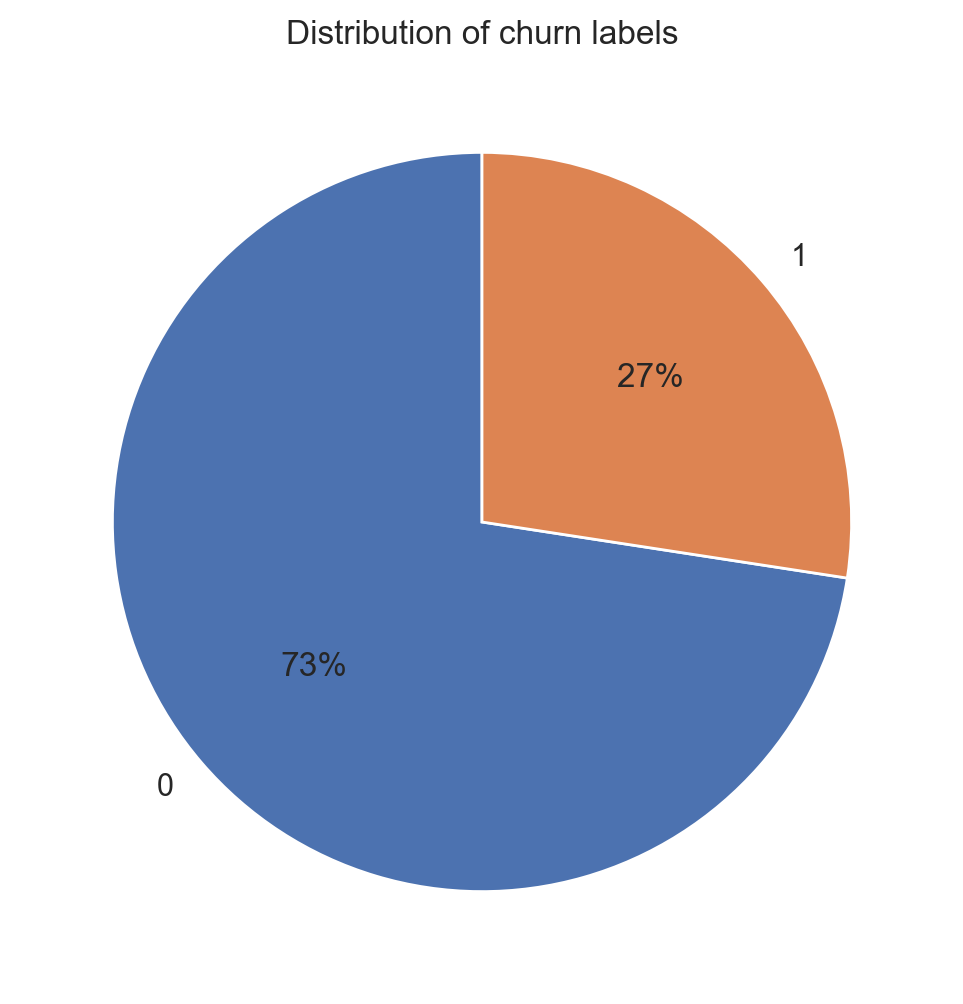

In [5]:
plot_pie(train_df, "churn")

The probability of churning is a business metric: *churn rate*. One way to get it is to compute the mean of positive examples in historical data.

In [6]:
train_churn_rate = train_df.churn.mean()
val_churn_rate = val_df.churn.mean()
print(f"Churn rate in train set: {train_churn_rate:.4f}")
print(f"Churn rate in validation set: {val_churn_rate:.4f}")

Churn rate in train set: 0.2742
Churn rate in validation set: 0.2613


### Analysis Outputs

- Approximately 27% of the customers stopped using the services (positive cases), and the rest remained as customers (negative cases).
- Since we have strong imbalance, trivial classifiers wont't work well because a dummy classifier will always predict the negative cases to get a high score.
- We will need special imbalanced classification methods to build a good classifier.

## Feature Analysis

In [7]:
numeric_variables = [
    "tenure", 
    "monthlycharges", 
    "totalcharges"
]

categorical_variables = [
    var for var in train_df.columns
    if var not in numeric_variables
    and var != "churn"
]

Let's examine the distributions. The goal is to categorize the features to better understand their characteristics, identify any necessary transformations, and uncover potential data bugs that need to be handled.

### Numeric Variables

In [8]:
from churn_detection.utils import get_distribution_info

In [9]:
get_distribution_info(train_df[numeric_variables])

-----------------------------------
Distribution analysis:
                     mean      50%        std
tenure            32.2483    29.00    24.5563
monthlycharges    64.9680    70.30    30.1023
totalcharges    2290.7678  1397.95  2279.8963
-----------------------------------
Variable ranges:
                  min      max
tenure           0.00    72.00
monthlycharges  18.25   118.65
totalcharges     0.00  8684.80
-----------------------------------
Quartile dispersion coefficients:
tenure -> 0.75
monthlycharges -> 0.43
totalcharges -> 0.81
-----------------------------------
Kurtosis:
tenure            1.3894
monthlycharges    1.2458
totalcharges      0.2748
dtype: float64
-----------------------------------
Skewness:
tenure            0.2366
monthlycharges    0.2249
totalcharges      0.9451
dtype: float64



In [10]:
from churn_detection.visualization import plot_hists, plot_boxes, plot_stem

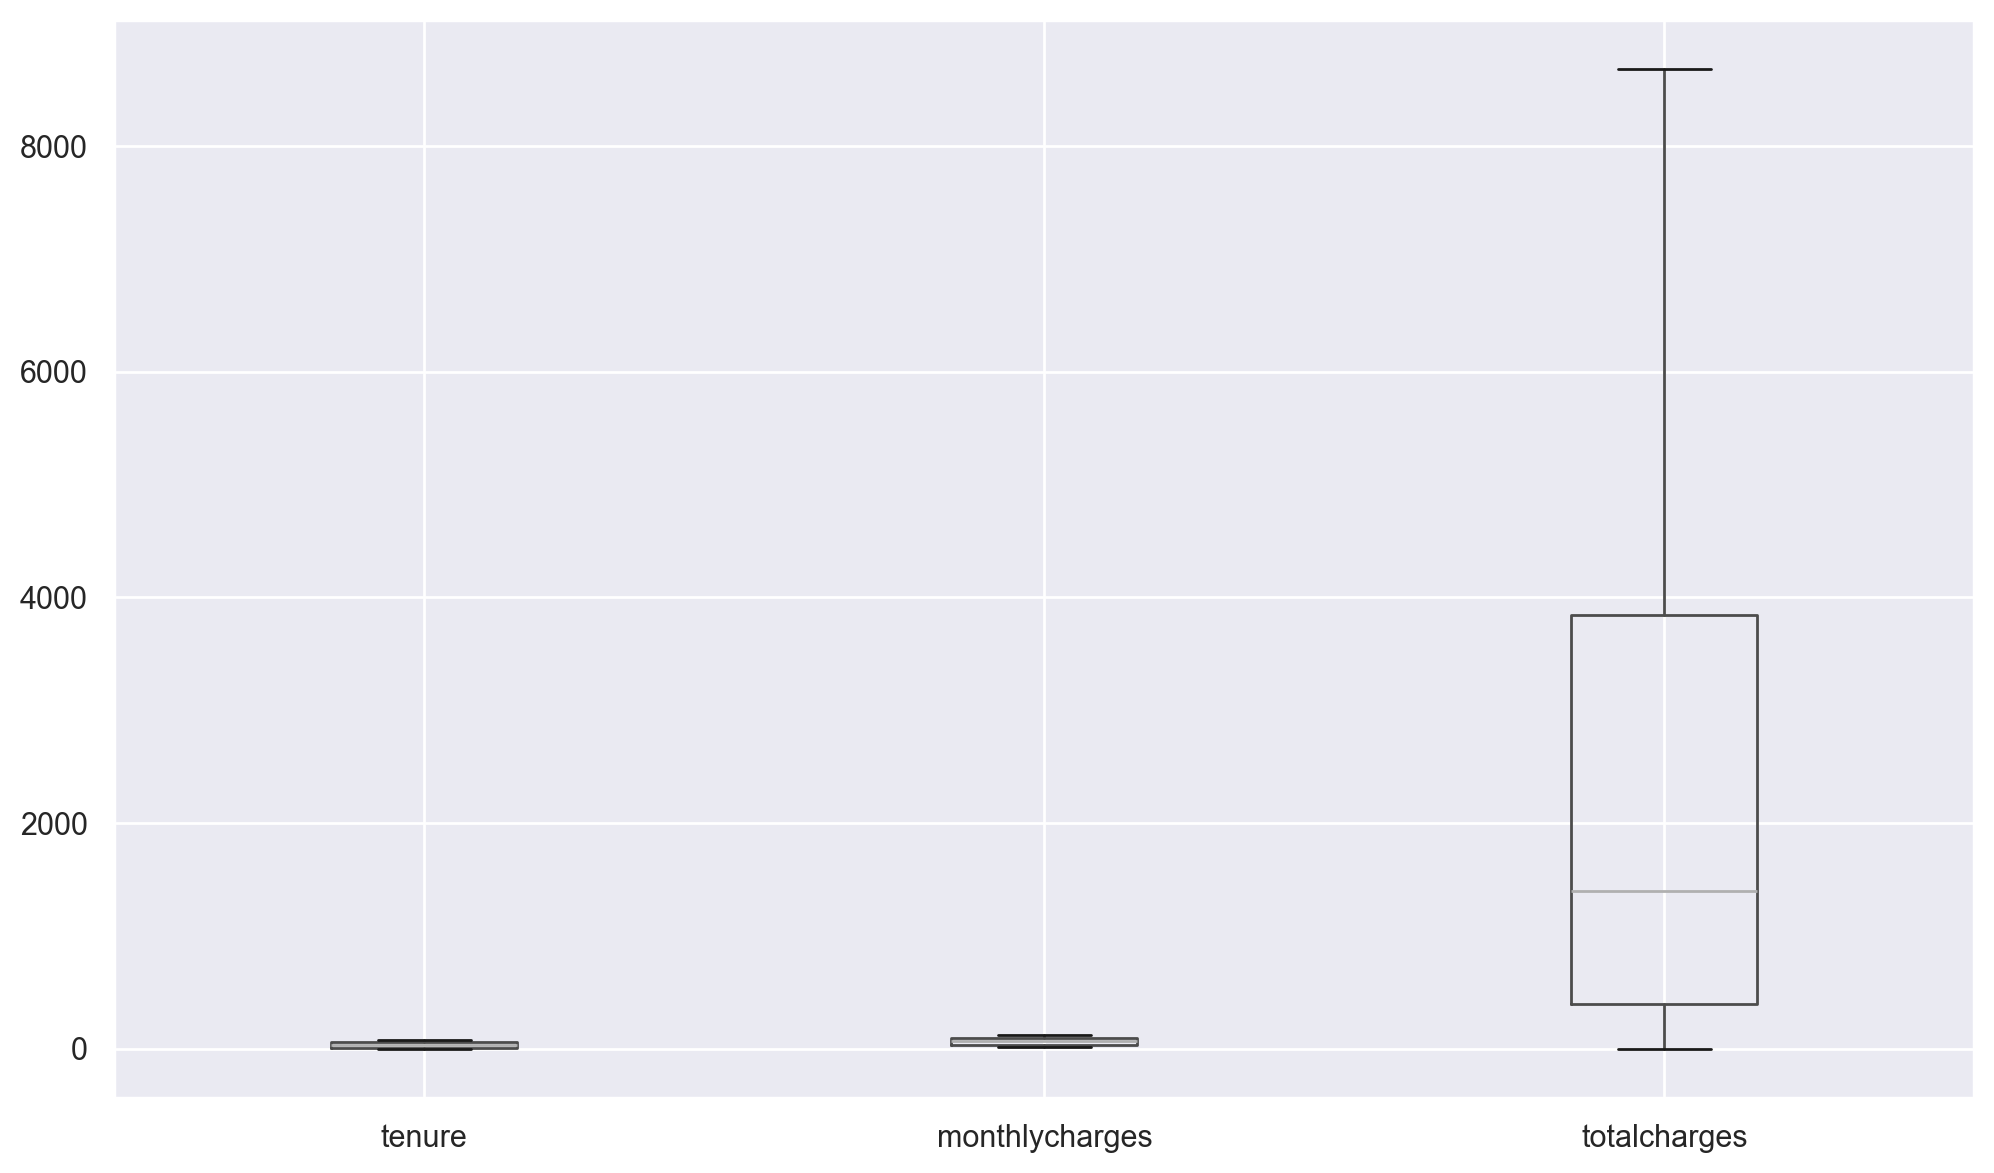

In [11]:
plot_boxes(train_df[numeric_variables])

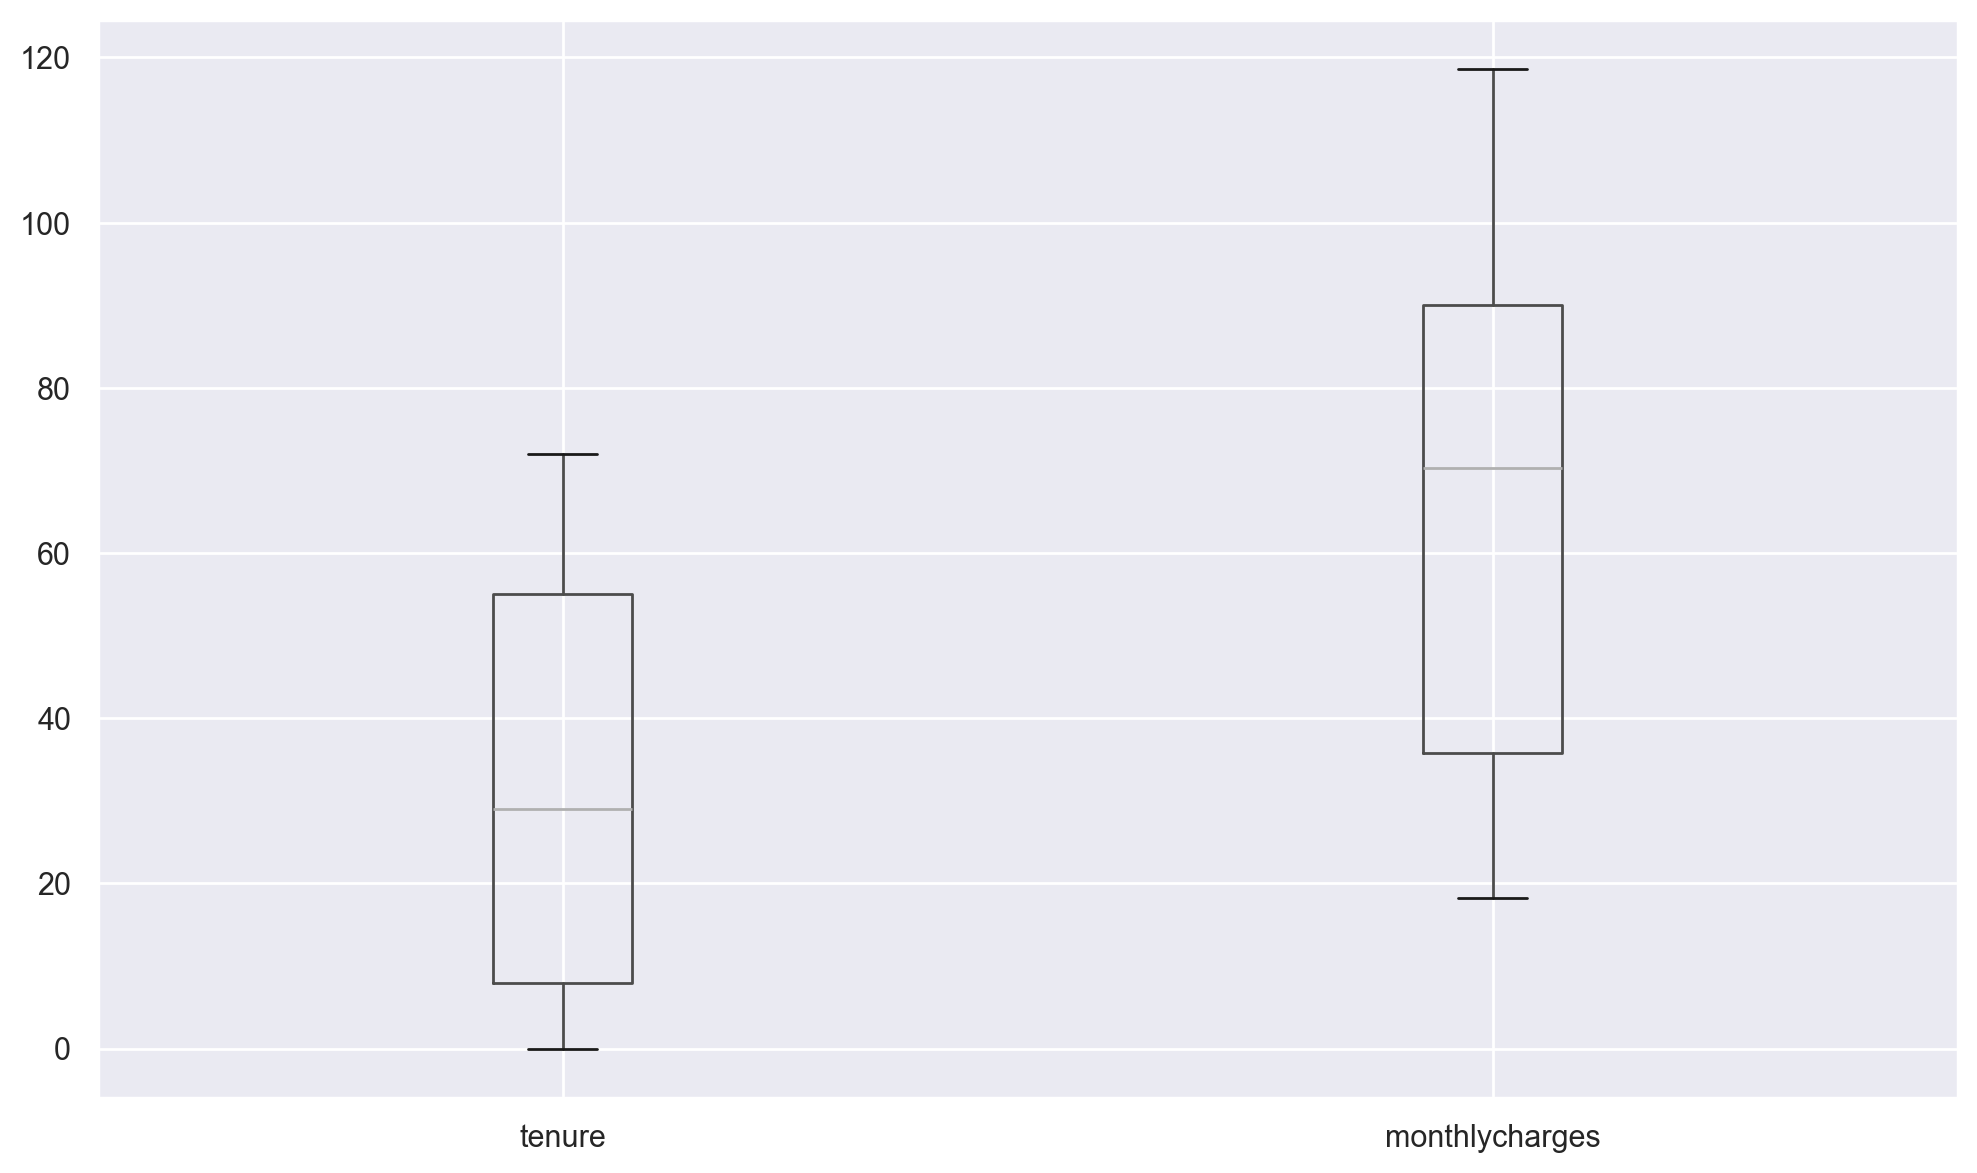

In [12]:
plot_boxes(train_df[numeric_variables[:-1]])

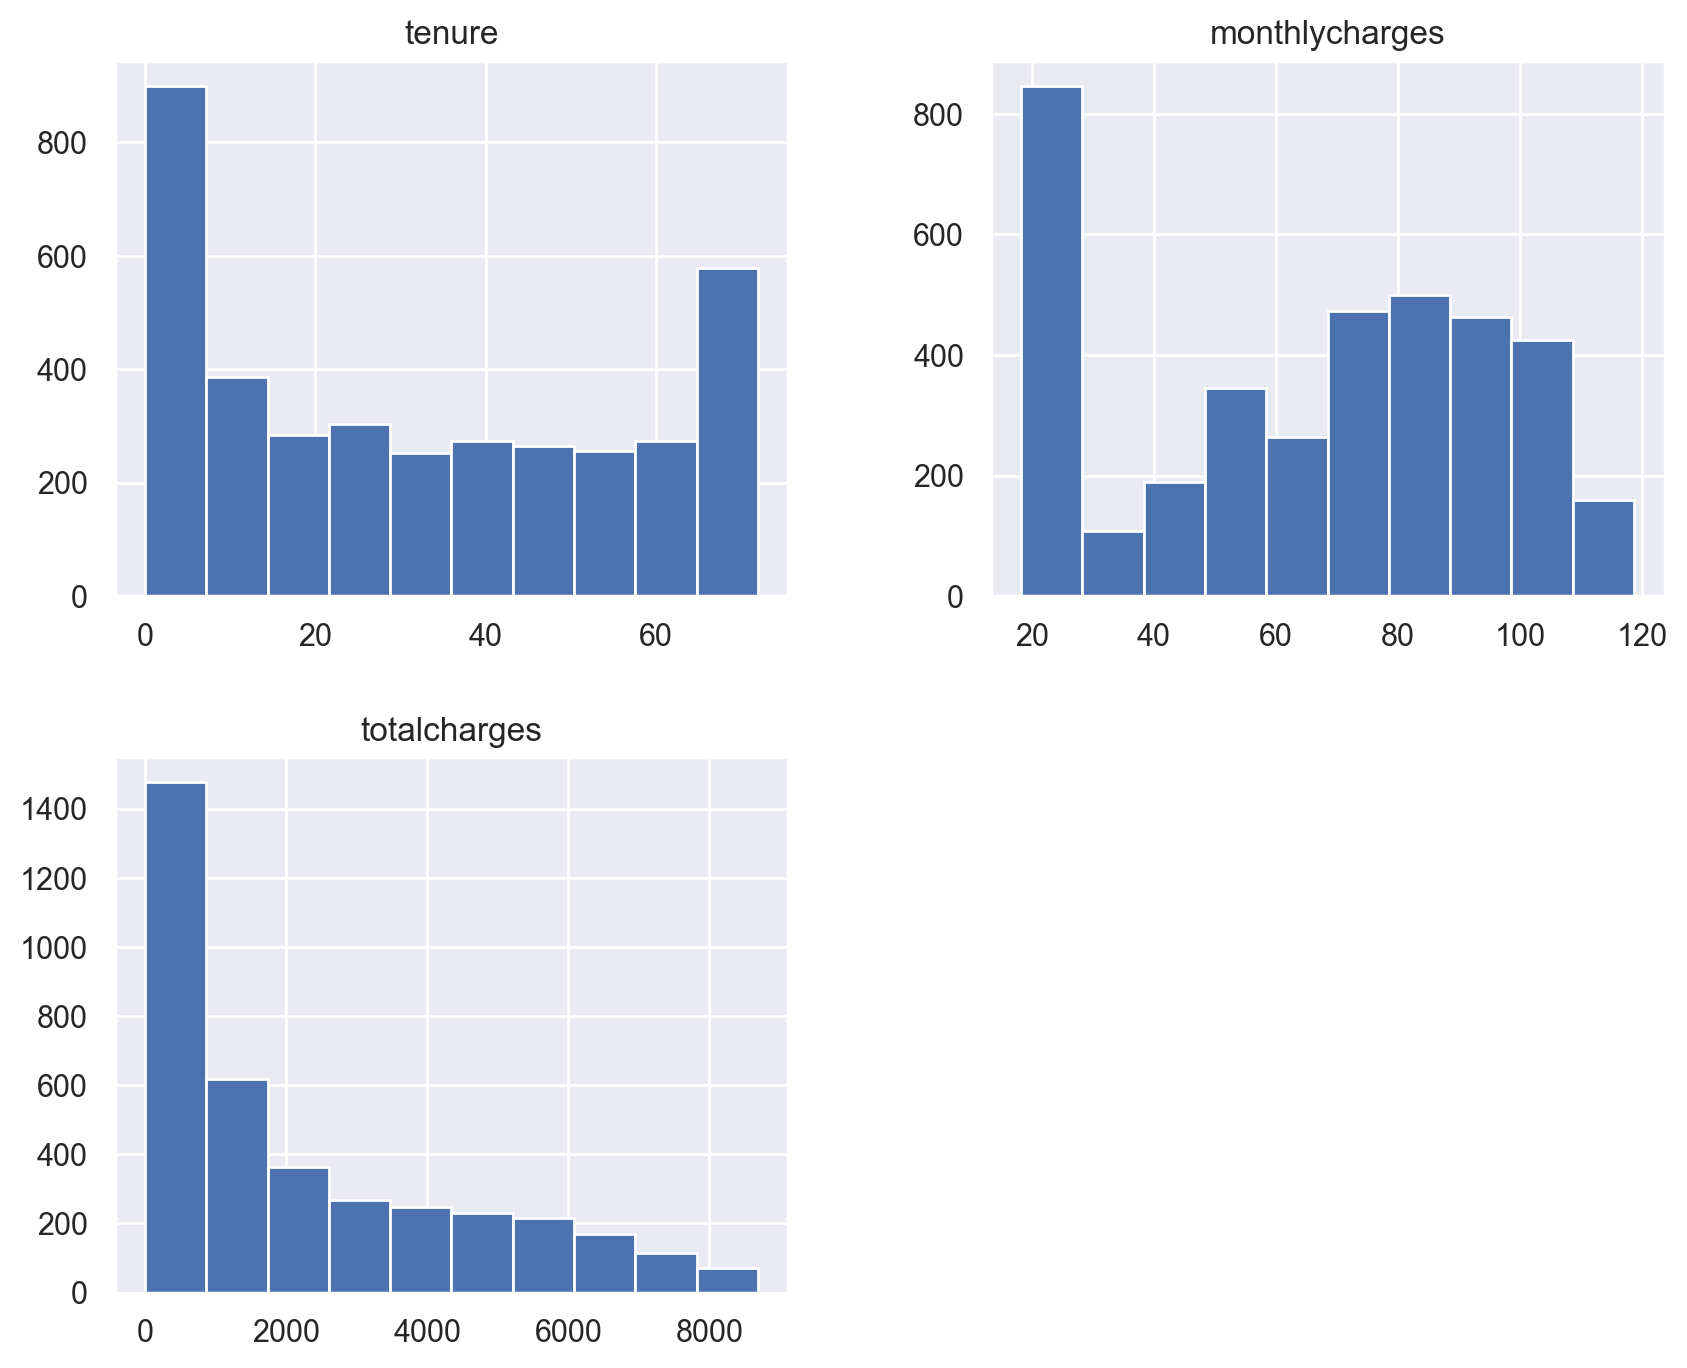

In [13]:
plot_hists(train_df[numeric_variables], size=(10,8))

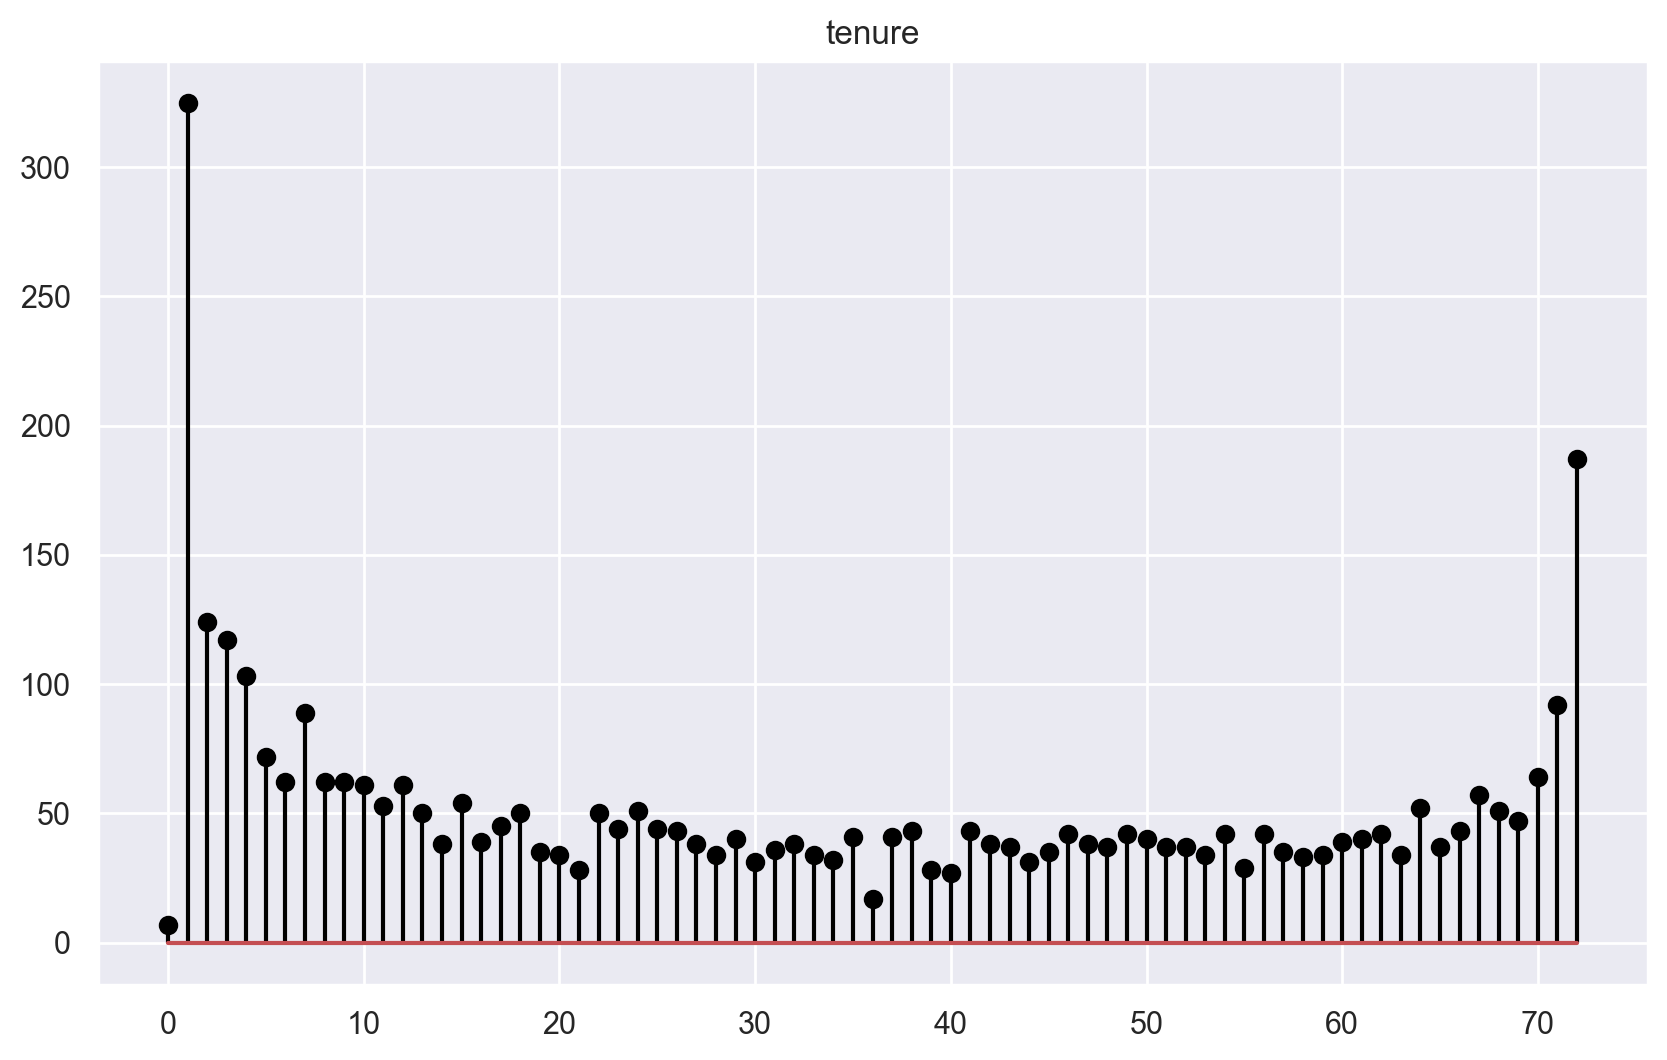

In [14]:
plot_stem(train_df, count_var="tenure", size=(10, 6))

#### Univariate Analysis Outputs

- There are different shapes and scales of distributions: spread and mean are differing.
- tenure has 2 modes and a wide range, suggesting a mix of new and long-term customers. The value of 0 for tenure indicates new customers who may have just started their subscriptions. These are not outliers but represent a logical edge case.
- monthlycharges appears to have a consistent spread, with a slightly higher mean value. There are no apparent extreme outliers in this column. The distribution appears reasonable, given the range of service charges.
- totalcharges has a high variance and is skewed, indicating variability in total billing across customers. A very low values should correspond to customers with very short tenures.

Let's inspect multivariate data.

In [15]:
from churn_detection.visualization import plot_correlation_info, plot_pairs

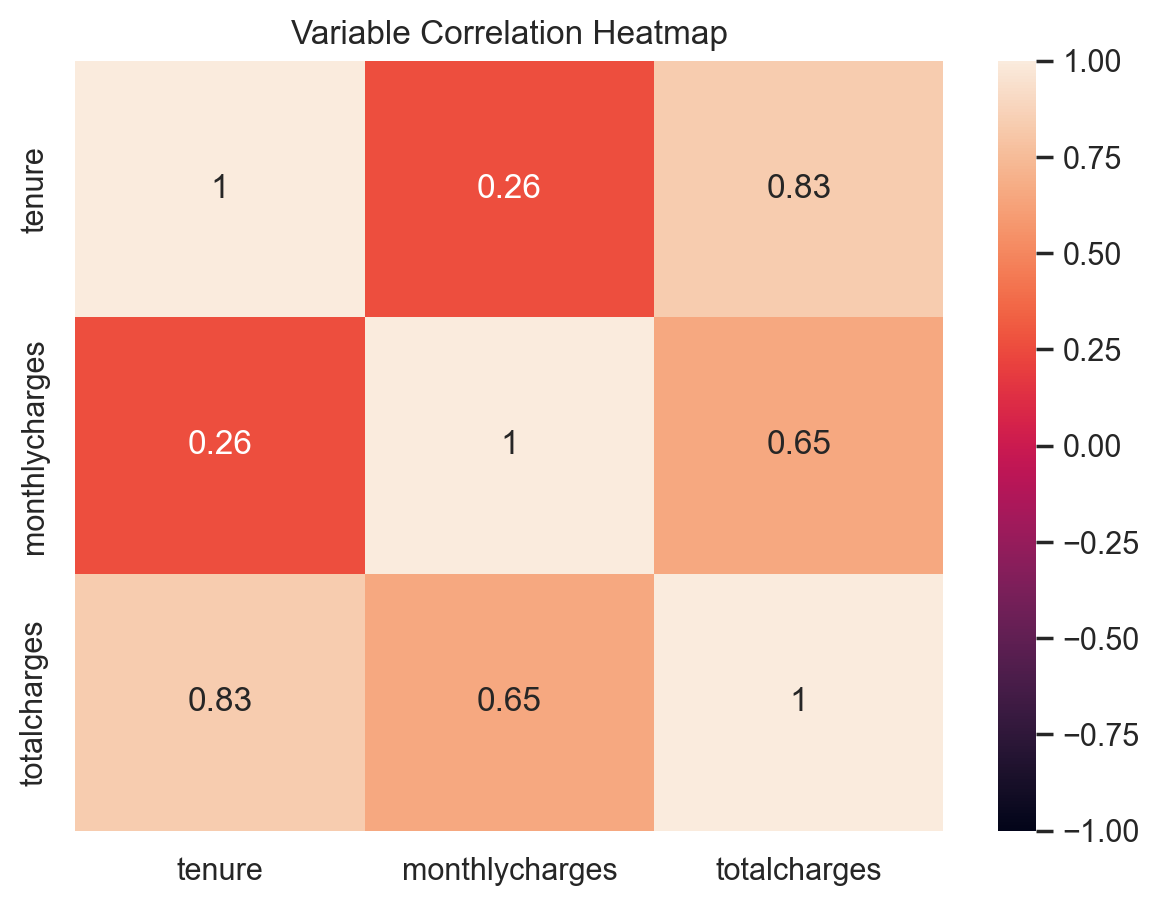

In [16]:
plot_correlation_info(train_df[numeric_variables], size=(7, 5))

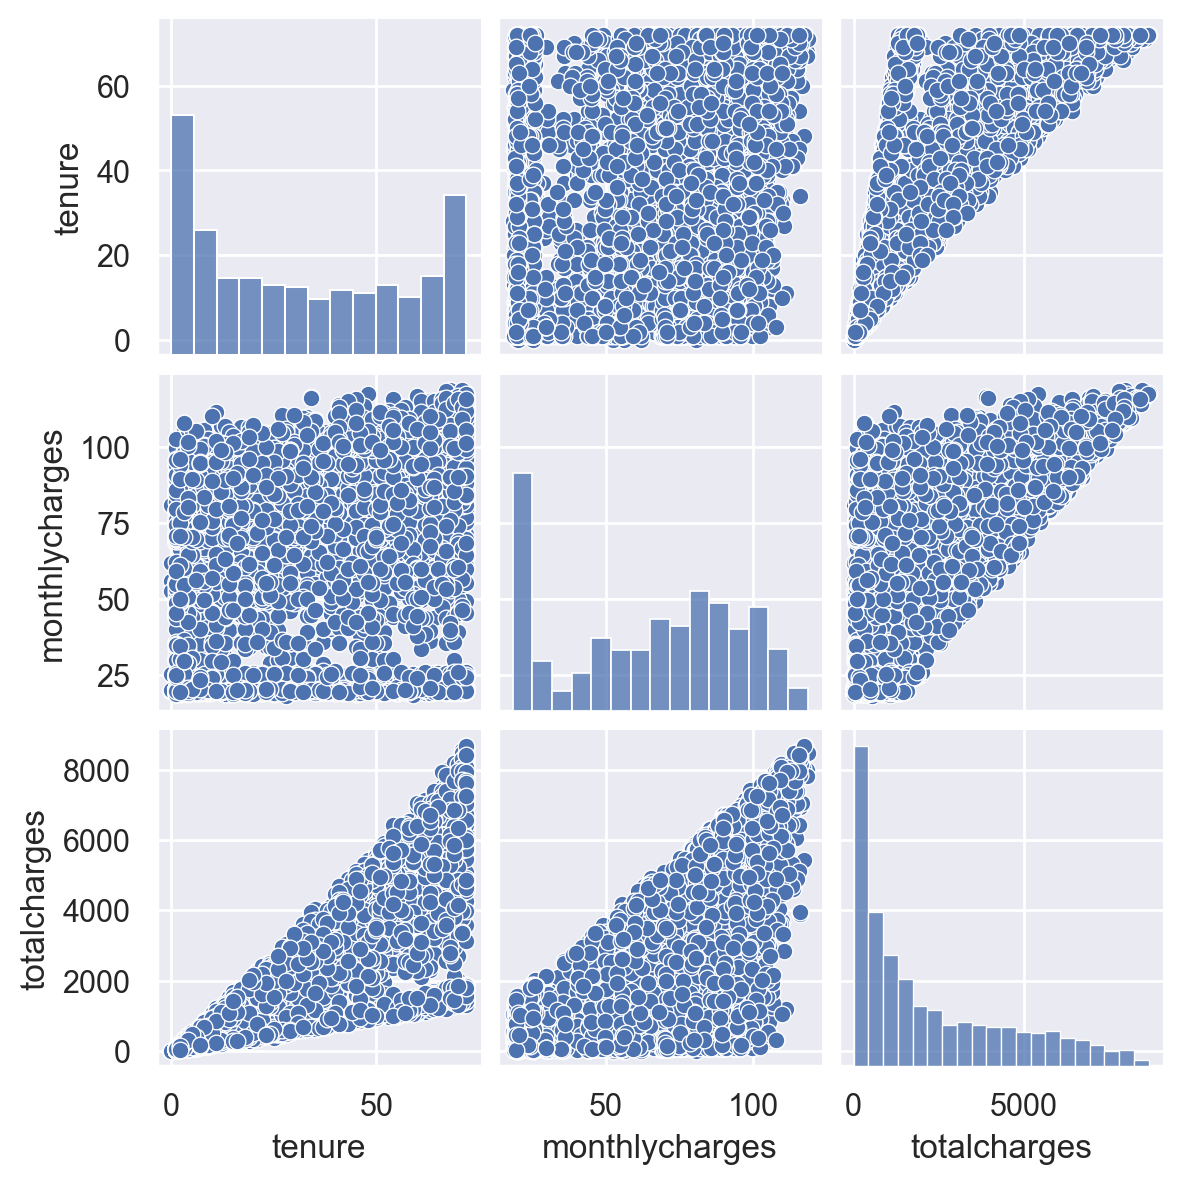

In [17]:
plot_pairs(train_df[numeric_variables], height=2)

#### Multivariate Analysis Outputs

- tenure vs. totalcharges: high positive correlation; naturally customers with longer tenure tend to accumulate higher total charges.
- monthlycharges vs. totalcharges: moderate positive correlation; most of the time higher monthly charges contribute to higher total charges.
- tenure vs. monthlycharges: weak correlation; hard to interpret. How long customers stay is really independant of monthly charges ? All scenarios are possible.

### Categorical Variables

These features have special data issues like high cardinality, imbalanced, rare labels, mixed values or inappropriate categories. Let's inspect their characteristics and associations.

In [18]:
from churn_detection.visualization import plot_card

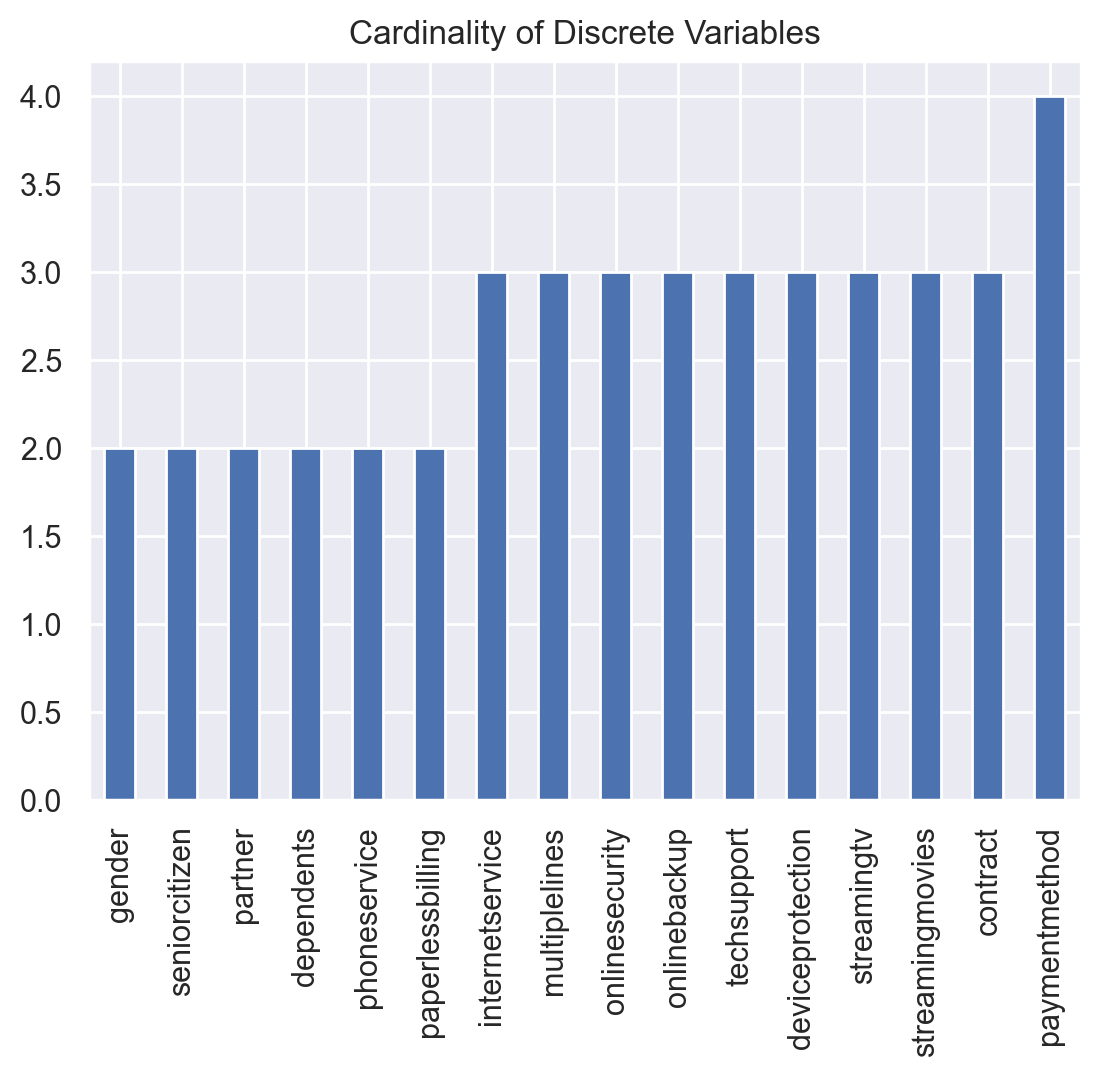

In [19]:
plot_card(train_df[categorical_variables])

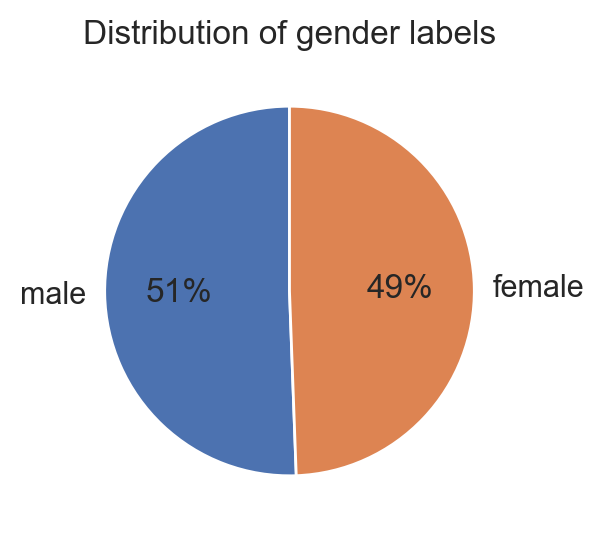

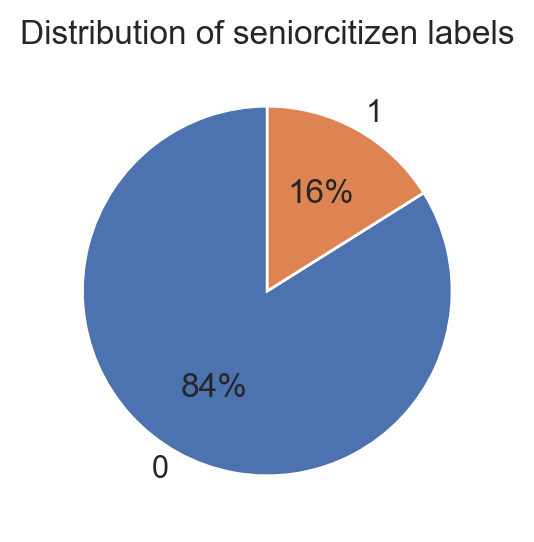

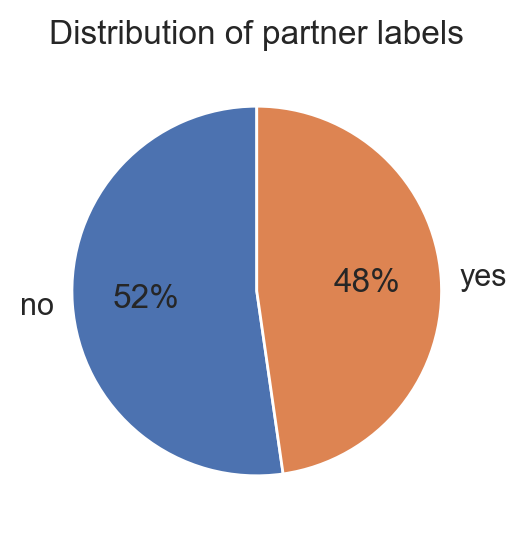

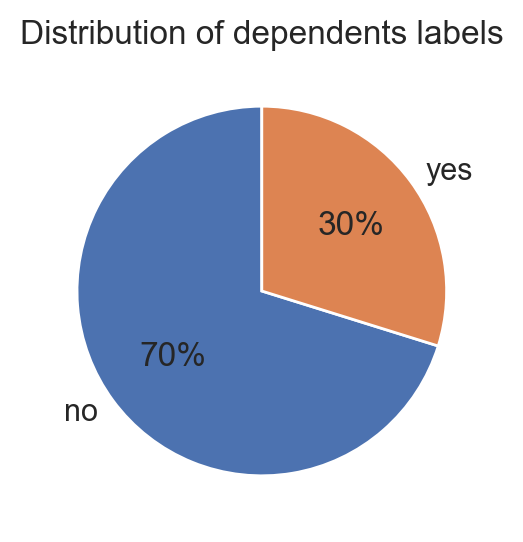

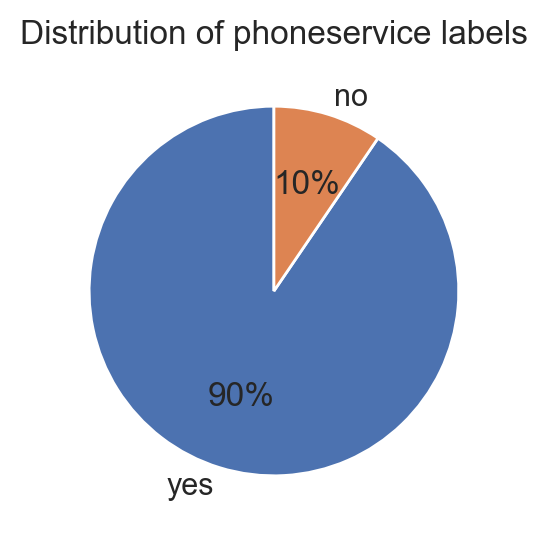

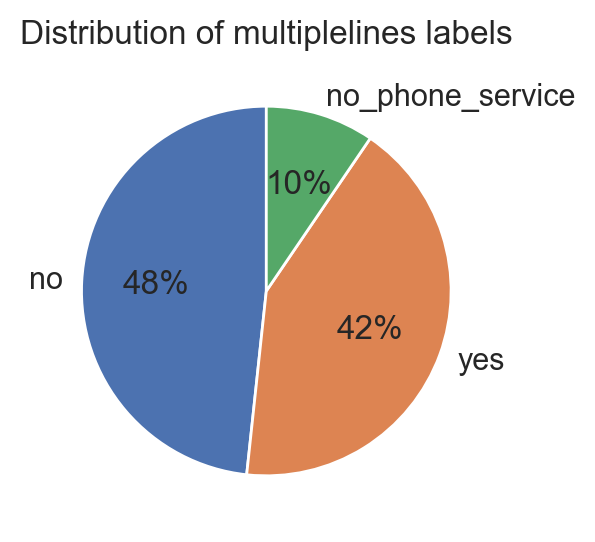

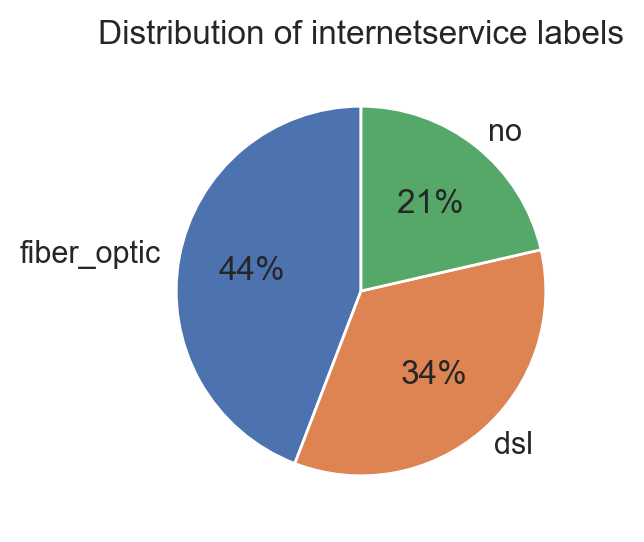

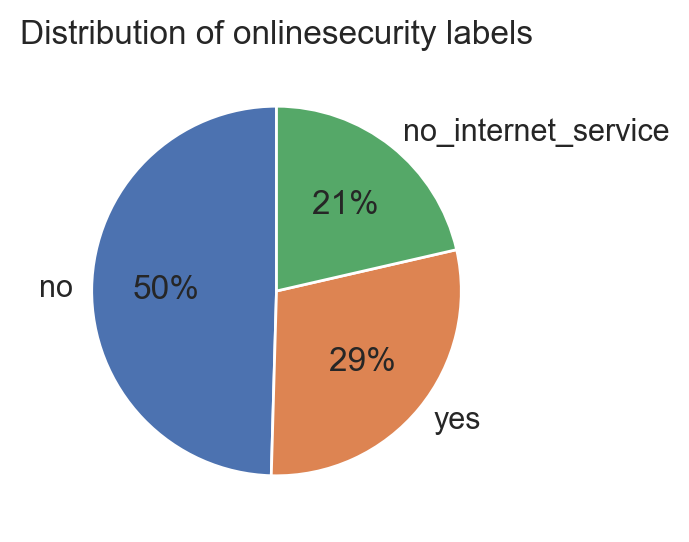

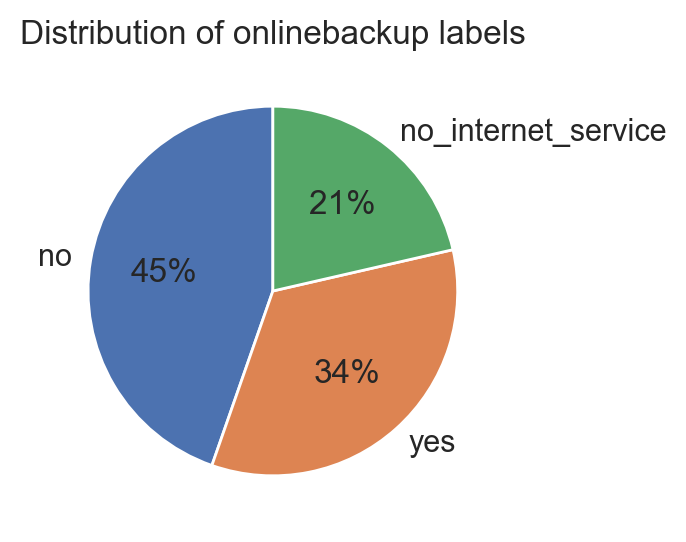

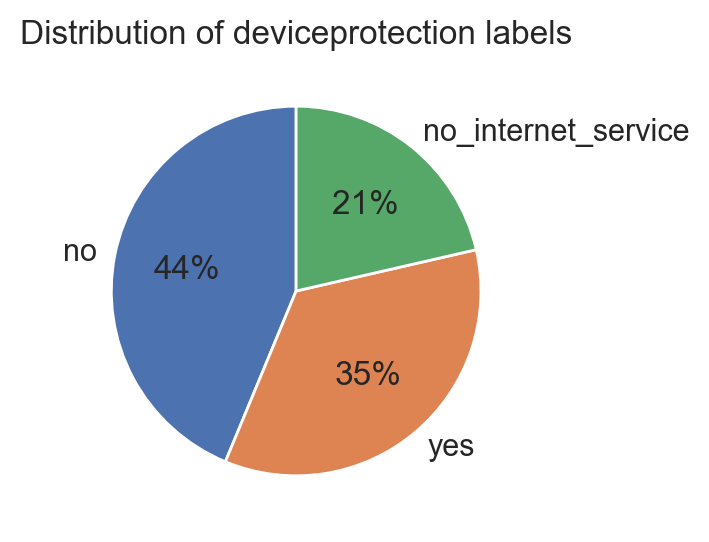

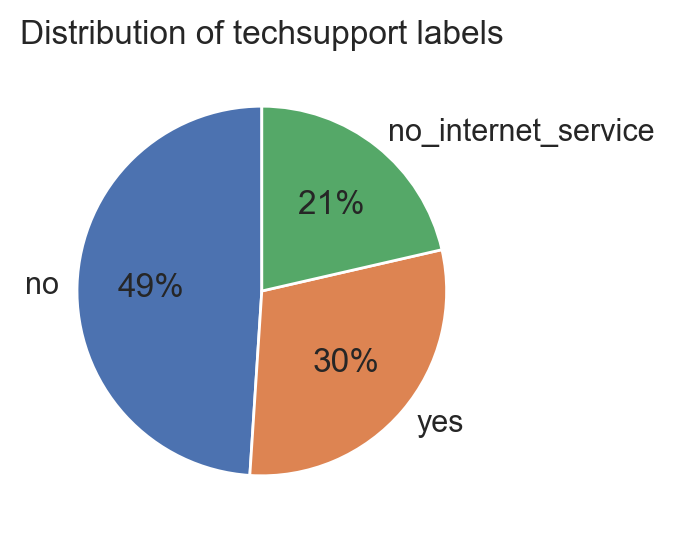

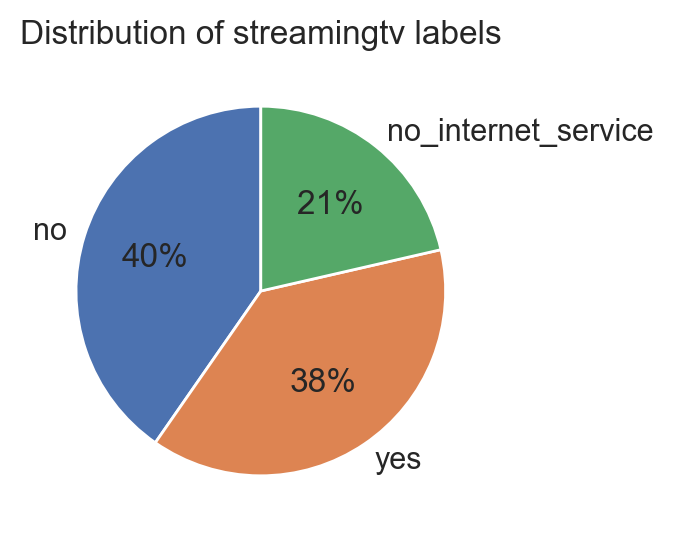

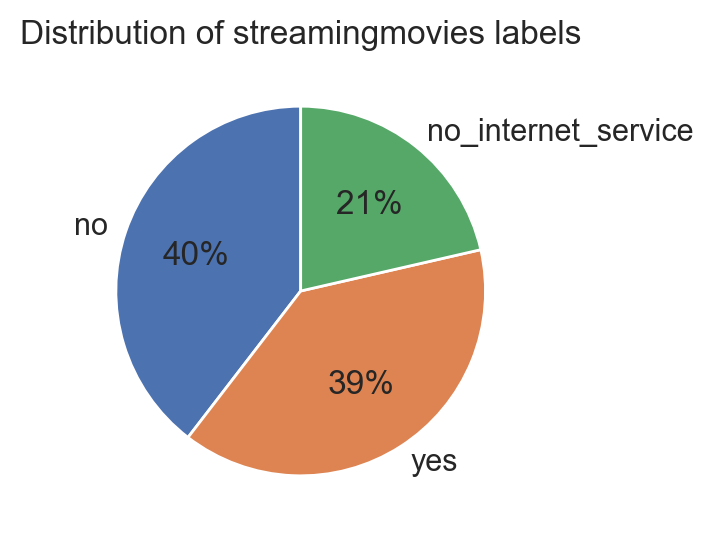

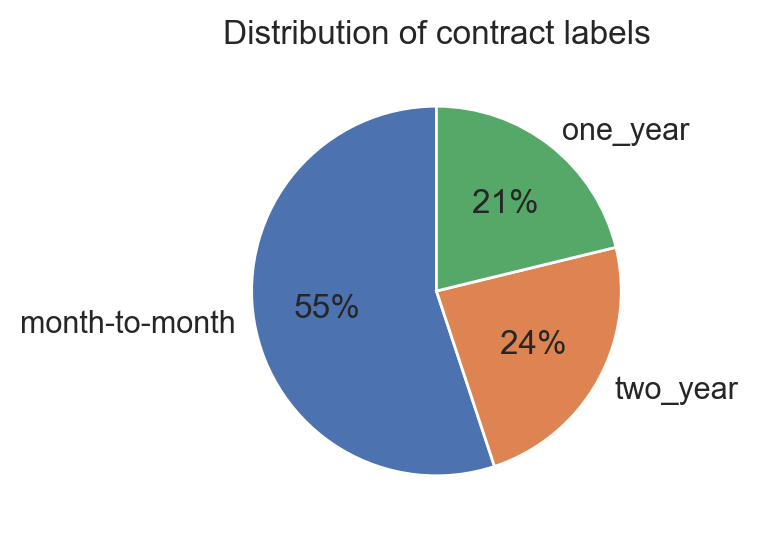

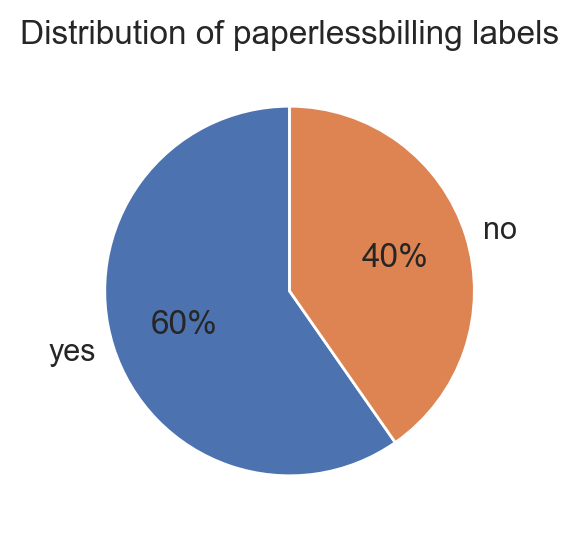

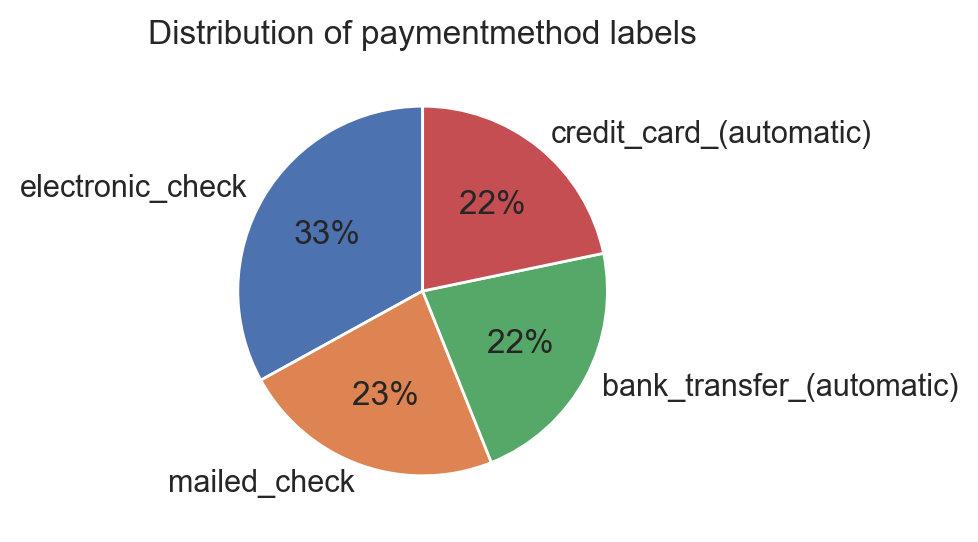

In [20]:
for feat in categorical_variables:
    plot_pie(train_df, feat, size=(3,3))
    print()

#### Univariate Analysis Outputs

- Cardinalities are very low, which is good news for potential categorie encoding.
- No rare labels were identified in the categorical variables based on the threshold of 5% of the dataset size. This indicates that all categories in the inspected variables have sufficient representation in the data.
- All categorical features could be casted as category.

Let's inspect association between categorical variables.

In [21]:
from churn_detection.visualization import plot_cramer

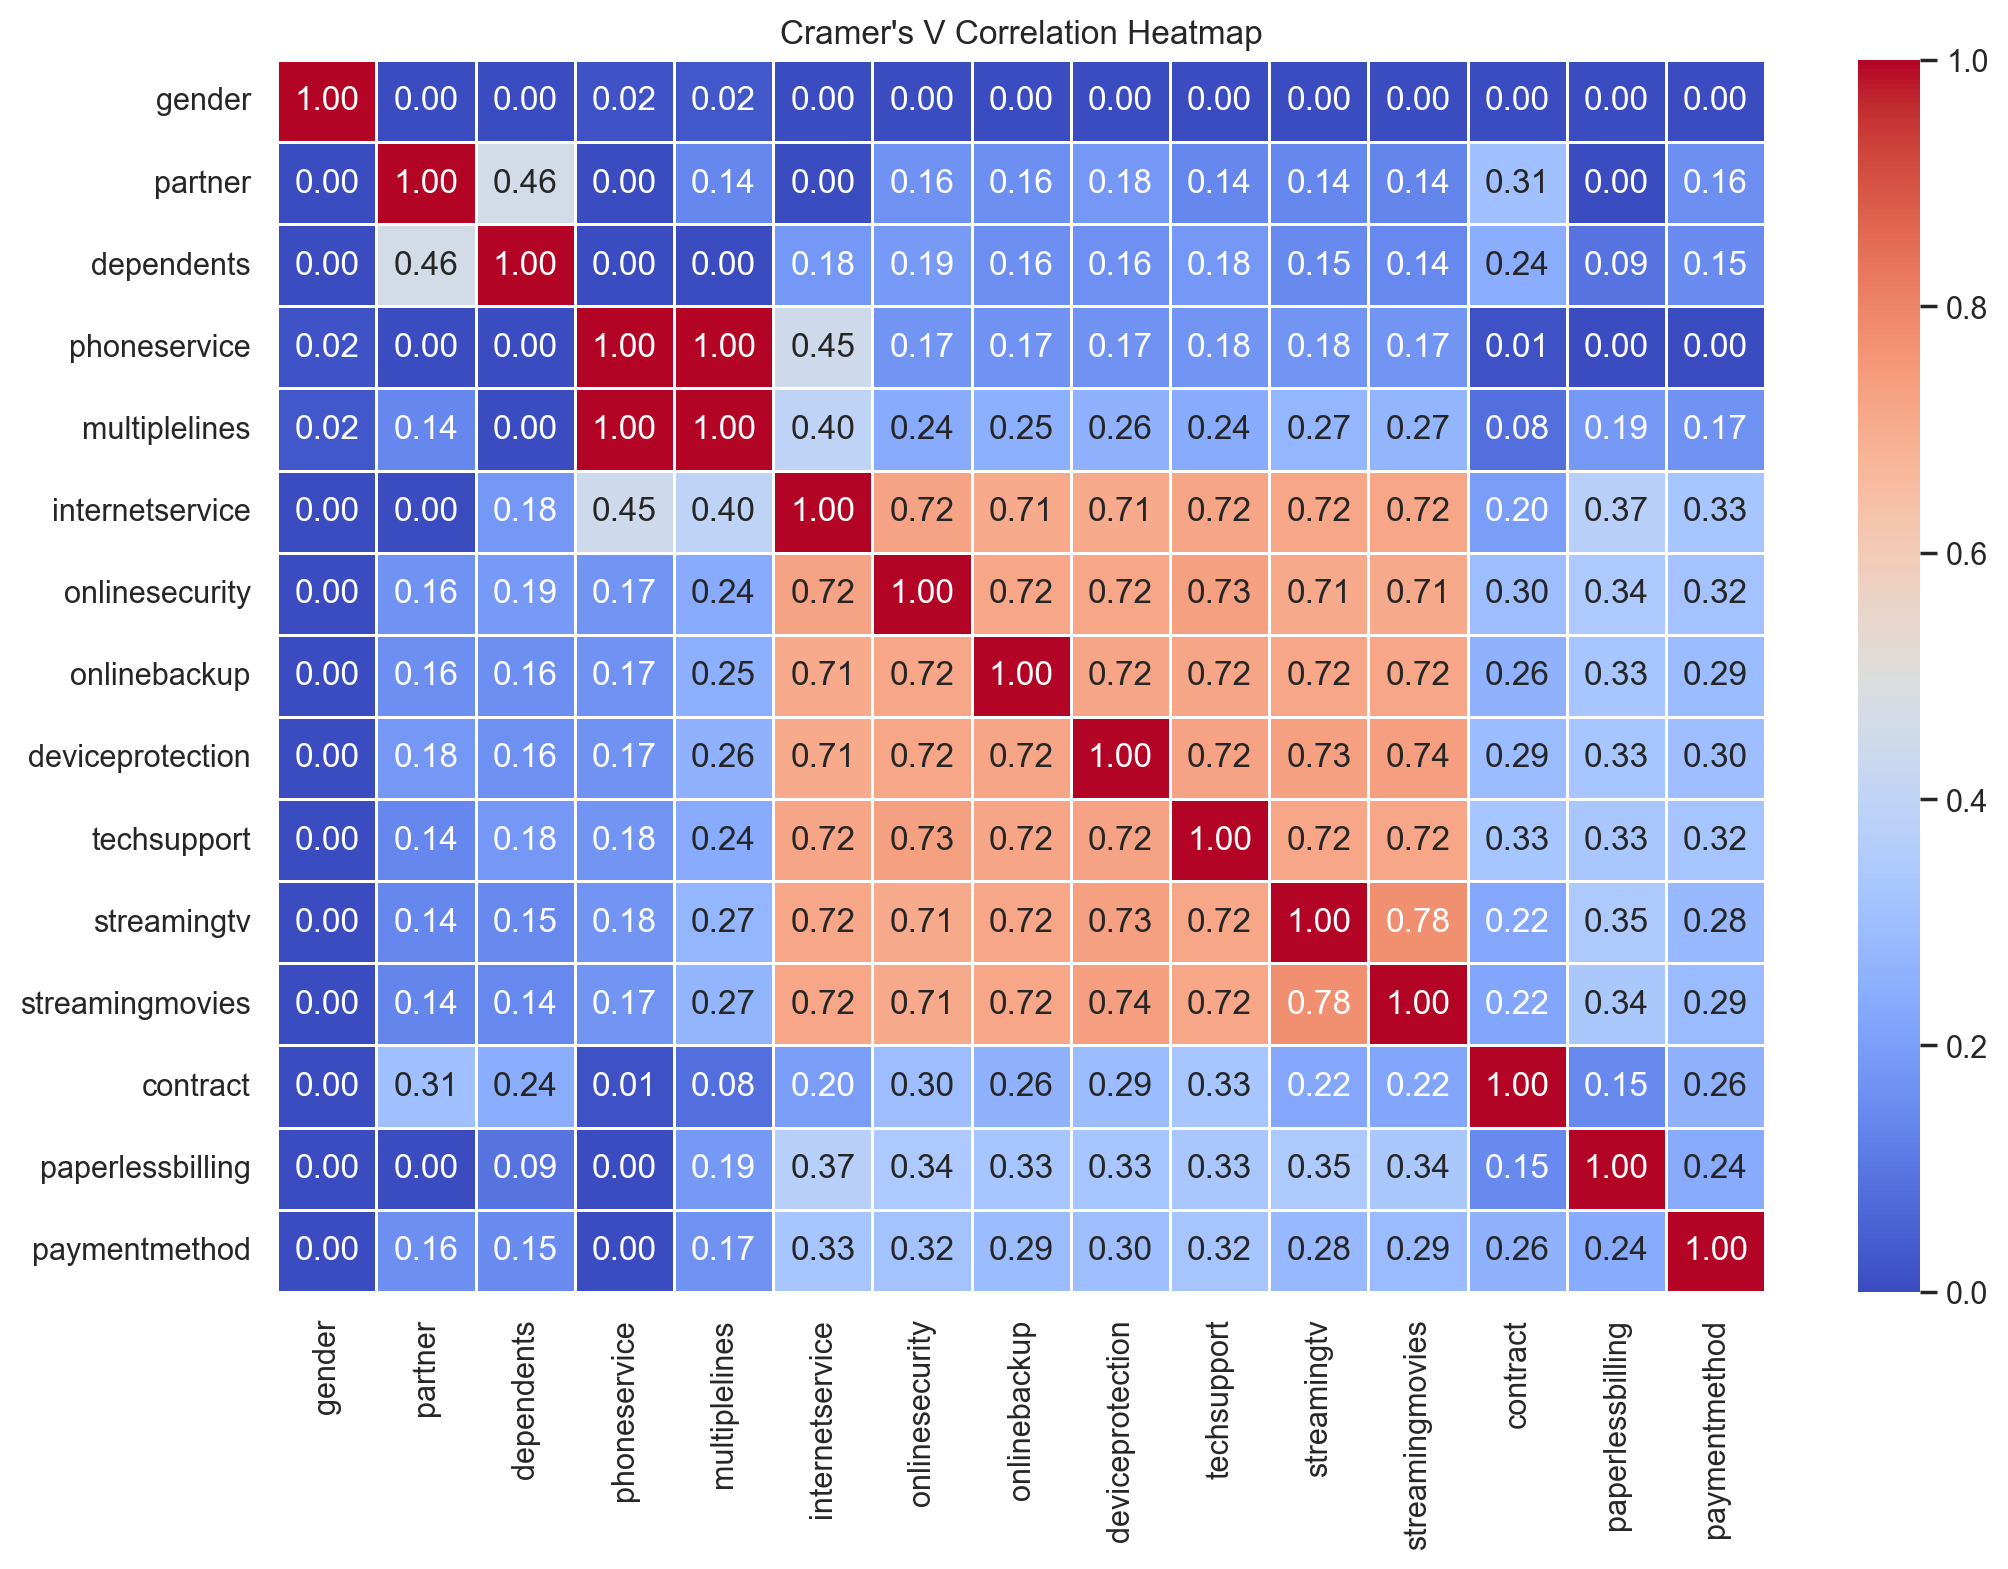

In [22]:
plot_cramer(train_df[categorical_variables], size=(12, 8))

In [23]:
from churn_detection.visualization import plot_bivariate_cat

In [24]:
train_df[categorical_variables] = train_df[categorical_variables].astype('category')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3774 entries, 2935 to 3405
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            3774 non-null   category
 1   seniorcitizen     3774 non-null   category
 2   partner           3774 non-null   category
 3   dependents        3774 non-null   category
 4   tenure            3774 non-null   int64   
 5   phoneservice      3774 non-null   category
 6   multiplelines     3774 non-null   category
 7   internetservice   3774 non-null   category
 8   onlinesecurity    3774 non-null   category
 9   onlinebackup      3774 non-null   category
 10  deviceprotection  3774 non-null   category
 11  techsupport       3774 non-null   category
 12  streamingtv       3774 non-null   category
 13  streamingmovies   3774 non-null   category
 14  contract          3774 non-null   category
 15  paperlessbilling  3774 non-null   category
 16  paymentmethod     3774 non

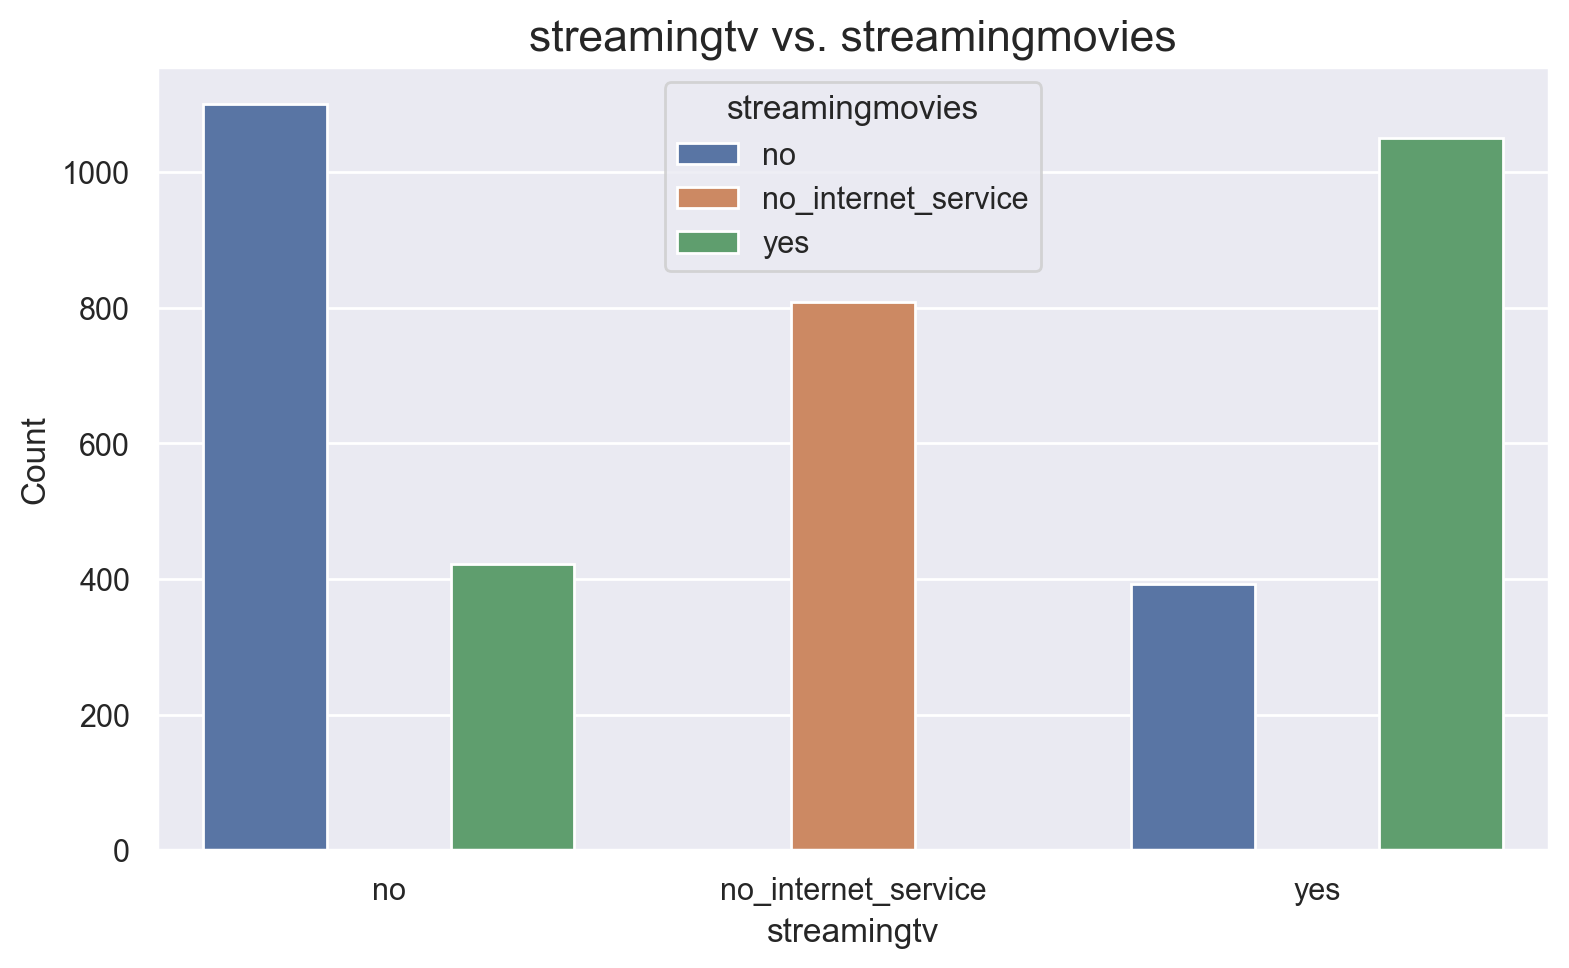

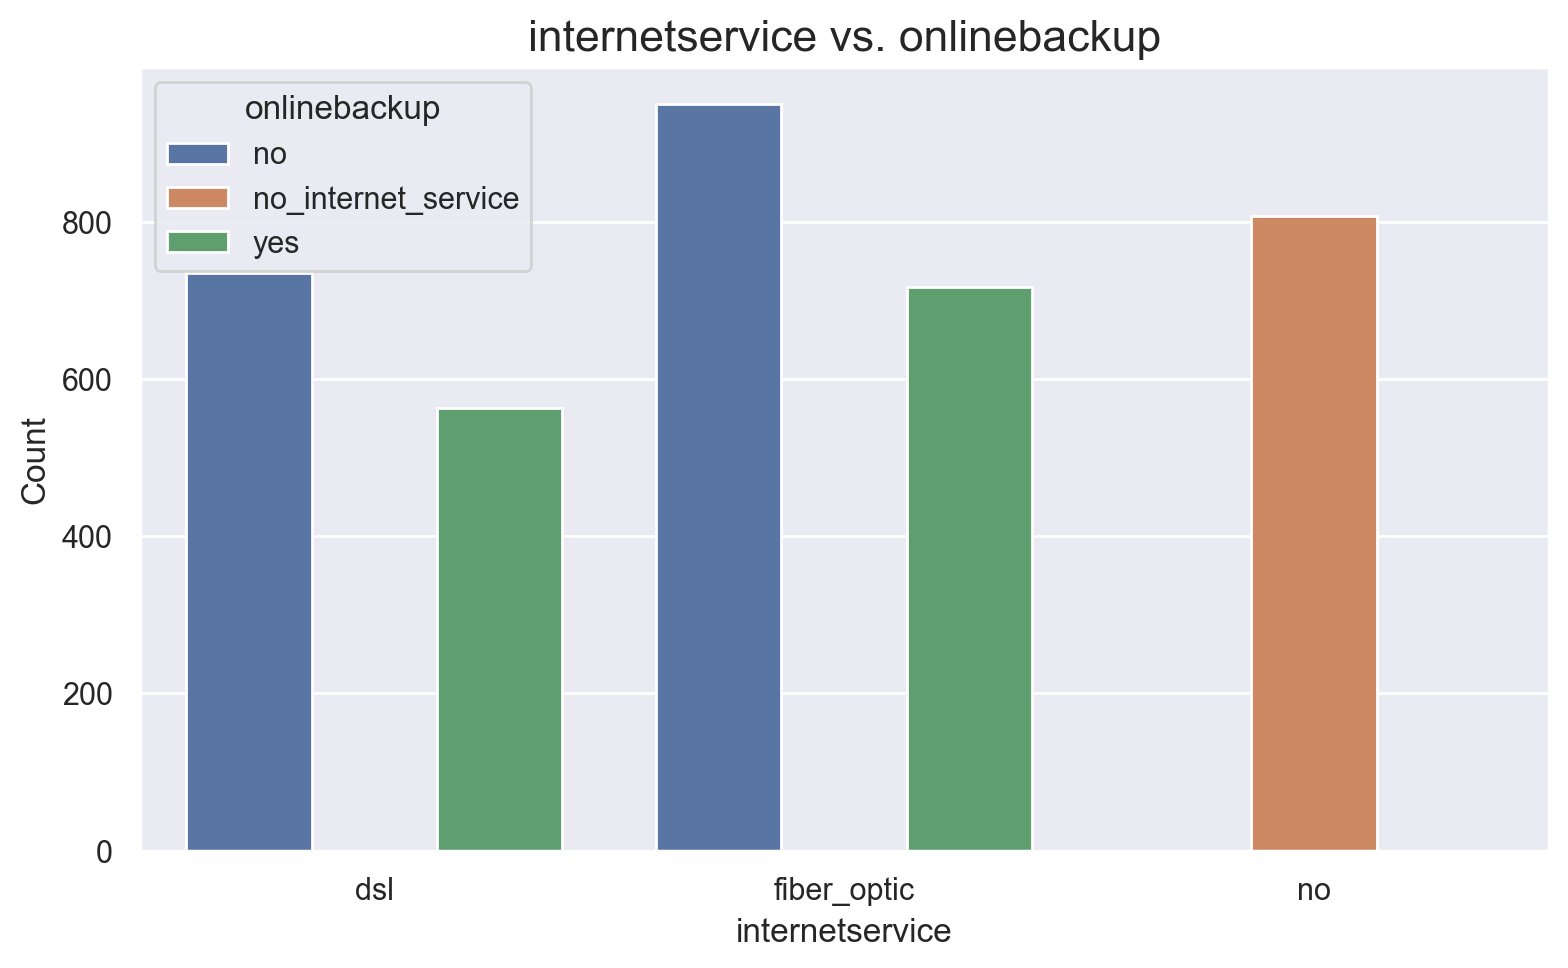

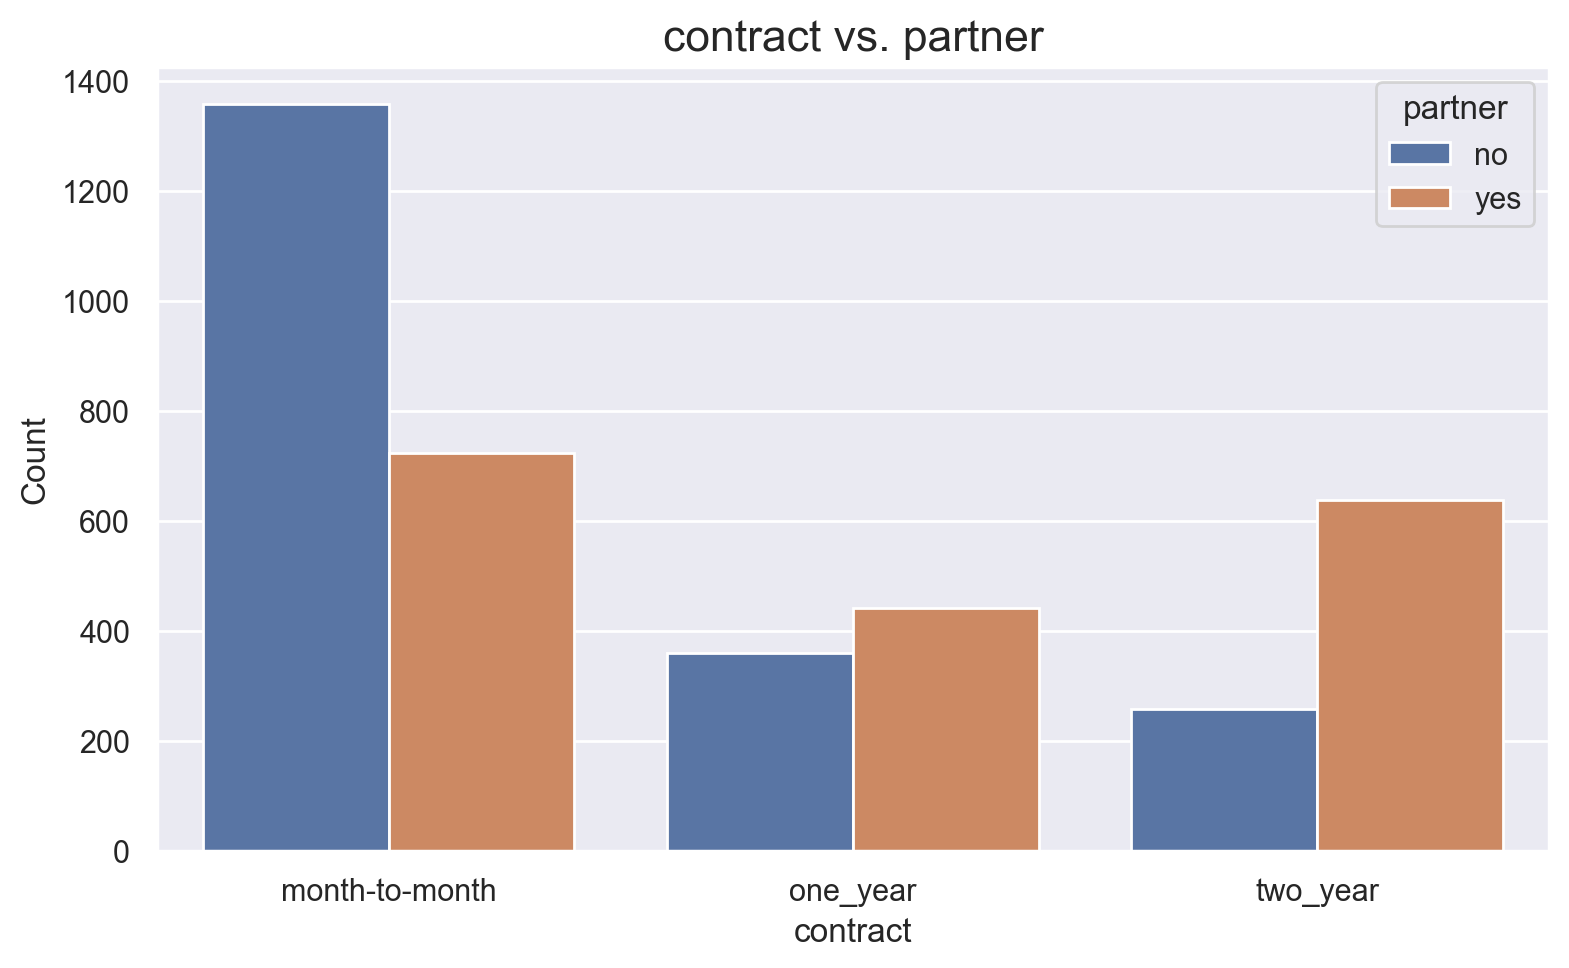

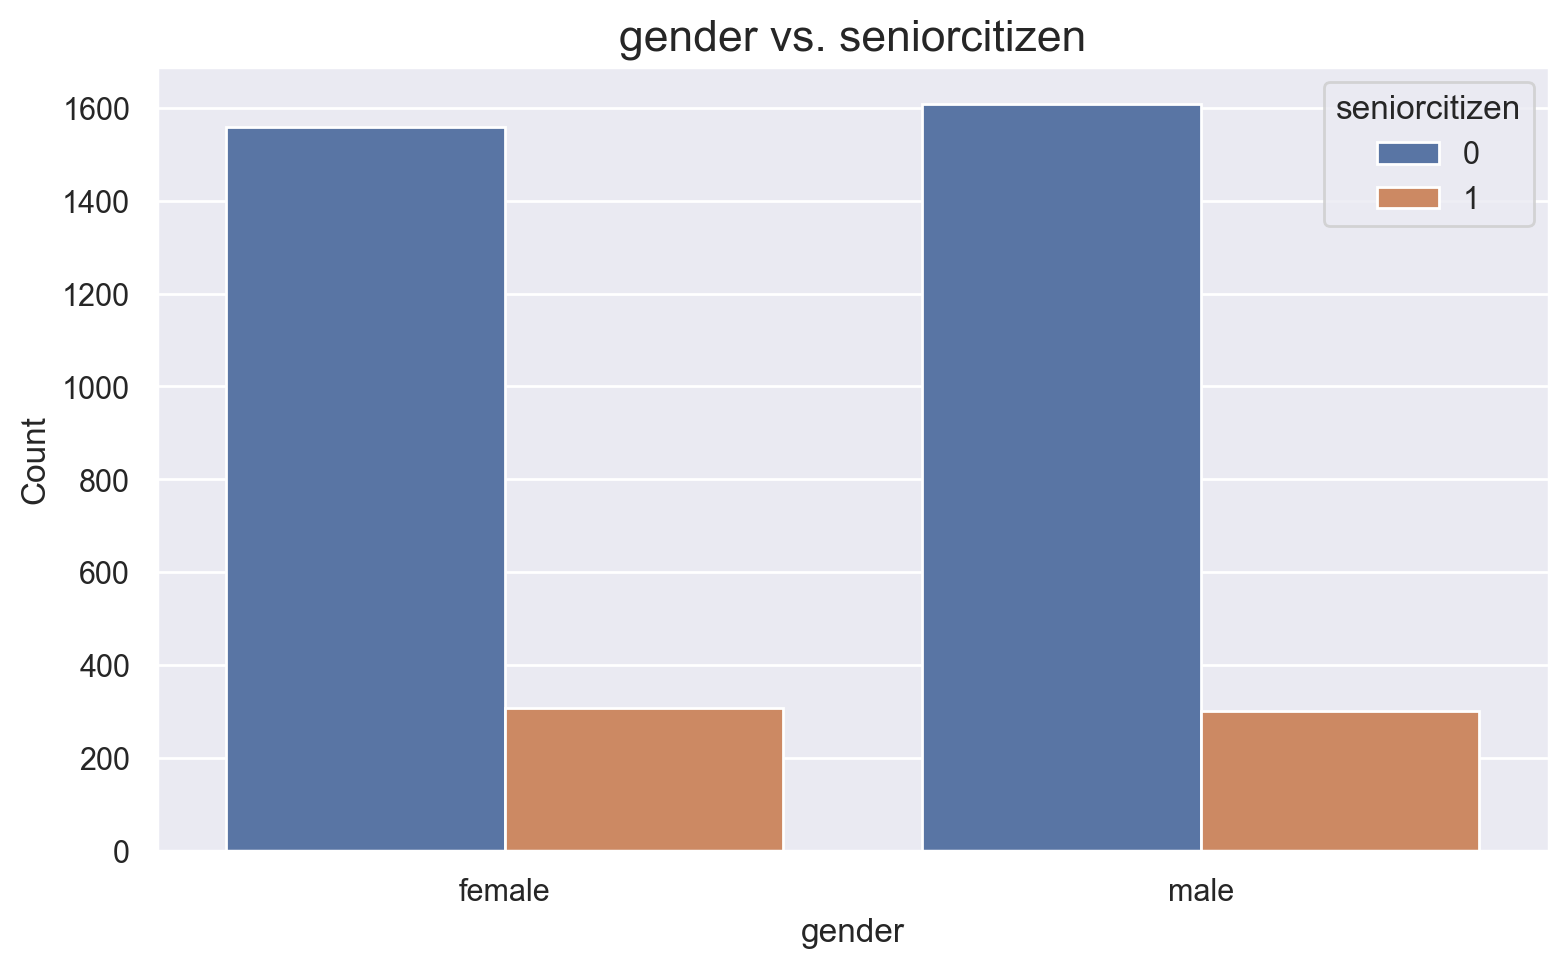

In [25]:
plot_bivariate_cat(train_df, x="streamingtv", y="streamingmovies")
plot_bivariate_cat(train_df, x="internetservice", y="onlinebackup")
plot_bivariate_cat(train_df, x="contract", y="partner")
plot_bivariate_cat(train_df, x="gender", y="seniorcitizen")

#### Multivariate Analysis Outputs

- High correlation exists between Services-based features. For example streamingtv Vs. streamingmovies: customers who have one service are very likely to have the other.
- We have moderate correlations too. For example contract Vs. partner, which indicates that relationship status might influence contract type.
- Low correlations: oddly gender shows no or very low correlation with other variables. It presence doesn't change anything in categorical data.
- phoneservice and multiplelines suggests strong collinearity. Given this dependency, it may be redundant to include both variables in a classifier.